In [26]:
from dask.diagnostics import ProgressBar
from dask.distributed import Client
from networkx.algorithms.community import greedy_modularity_communities
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from warnings import simplefilter

plt.rcParams['figure.dpi'] = 200
simplefilter(action='ignore', category=FutureWarning)

import community as community_louvain
import dask.dataframe as dd
import html
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import psutil
import pandas as pd
import pickle as pkl
import re
import seaborn as sns
import time

### Network Generation [1:2]: The DataFrame

In [2]:
# Read the data
questions = pd.read_pickle('./pickle_dataframes/questions_with_sentiment.pkl')
answers = pd.concat([pd.read_pickle('./pickle_dataframes/answers_with_sentiment1.pkl'), 
                     pd.read_pickle('./pickle_dataframes/answers_with_sentiment2.pkl')]).reset_index(drop=True)
comments = pd.read_pickle('./pickle_dataframes/comments_with_sentiment.pkl')

users = pd.read_pickle('./pickle_dataframes/users_with_all_attributes.pkl')

users_with_all_attributes = pd.read_pickle('./pickle_dataframes/users_with_all_attributes.pkl')
users_with_all_attributes.head(2)

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,QuestionCount,AnswerCount,CommentCount,...,16,17,18,19,20,21,22,23,24,MostEngagedTopic
1,5,315,2012-12-04 20:36:06.517,2021-07-05 18:03:41.037,49,14,58,0.0,3.0,31.0,...,0.0,0.029412,0.029412,0.0,0.0,0.058824,0.0,0.0,0.176471,3.0
2,8,2777,2012-12-04 20:52:37.450,2022-07-31 22:39:03.850,832,37,5,0.0,13.0,10.0,...,0.0,0.000000,0.000000,0.0,0.0,0.391304,0.0,0.0,0.086957,21.0


In [3]:
# Preparing a list of question IDs
parent_list = questions.Id.tolist()

# Identifying Comments Associated with Questions and Answers
comments_on_questions = comments[comments['PostId'].isin(questions['Id'])]
comments_on_answers = comments[comments['PostId'].isin(answers['Id'])]

In [4]:
# Aggregating commenters by the post they commented on
comments_on_questions_agg = comments_on_questions.groupby('PostId')['UserId'].apply(list).reset_index()
comments_on_answers_agg = comments_on_answers.groupby('PostId')['UserId'].apply(list).reset_index()

In [5]:
# Mapping Answer IDs to their corresponding Question IDs
answer_to_question_map = answers.set_index('Id')['ParentId'].to_dict()
comments_on_answers_agg['MappedPostId'] = comments_on_answers_agg['PostId'].map(lambda x: answer_to_question_map.get(x, None))

# Filtering out None values which have no corresponding question
comments_on_answers_agg = comments_on_answers_agg[comments_on_answers_agg['MappedPostId'].notnull()]

In [6]:
# Creating a unified DataFrame for comment data
comments_combined = pd.concat([
    comments_on_questions_agg.rename(columns={'PostId': 'QuestionId', 'UserId': 'CommentOnQuestionUserId_list'}),
    comments_on_answers_agg.rename(columns={'MappedPostId': 'QuestionId', 'UserId': 'CommentOnAnswersUserId_list'})
], ignore_index=True)

# Replacing NaN values with empty lists
comments_combined['CommentOnQuestionUserId_list'] = comments_combined['CommentOnQuestionUserId_list'].apply(lambda x: x if isinstance(x, list) else [])
comments_combined['CommentOnAnswersUserId_list'] = comments_combined['CommentOnAnswersUserId_list'].apply(lambda x: x if isinstance(x, list) else [])

# Grouping and combining lists
comments_combined = comments_combined.groupby('QuestionId').agg(
    CommentOnQuestionUserId_list=('CommentOnQuestionUserId_list', lambda x: sum(x, [])),
    CommentOnAnswersUserId_list=('CommentOnAnswersUserId_list', lambda x: sum(x, []))
).reset_index()

In [7]:
# Filtering answers that are related to the collected questions
df_int = answers[answers.ParentId.isin(parent_list)]

In [8]:
# Grouping answers by their parent question and aggregating answerer user IDs
df_subpost = df_int.groupby('ParentId').agg(
    answers_UserId_list=('OwnerUserId', lambda x: list(x))
).reset_index(drop=False)

In [9]:
# Identifying original posters for each question
df_original_poster = questions[questions.Id.isin(df_int.ParentId.tolist())].copy()
df_original_poster = df_original_poster.groupby('Id').agg(
    original_poster_UserId=('OwnerUserId', lambda x: list(x))
)

In [10]:
# Merging to form a comprehensive DataFrame for graph construction
df_graph = pd.merge(
    left=df_original_poster,
    right=df_subpost,
    left_on='Id',
    right_on='ParentId'
)

# Cleaning up the 'original_poster' column
df_graph['original_poster_UserId'] = df_graph['original_poster_UserId'].apply(lambda x: x[0] if x else None)

# Integrating Comment Data with the Graph Data
df_graph = pd.merge(df_graph, comments_combined, left_on='ParentId', right_on='QuestionId', how='left')

In [11]:
df_graph['CommentOnQuestionUserId_list'] = df_graph['CommentOnQuestionUserId_list'].apply(lambda x: x if isinstance(x, list) else [])
df_graph['CommentOnAnswersUserId_list'] = df_graph['CommentOnAnswersUserId_list'].apply(lambda x: x if isinstance(x, list) else [])
df_graph = df_graph[df_graph['original_poster_UserId'] != -1]

#### If you want to see how to get each of the values in df_graph's columns expand below rows: 

In [12]:
# displaying the different columns of row 1 manually
df_graph.head(1)

,original_poster_UserId,ParentId,answers_UserId_list,QuestionId,CommentOnQuestionUserId_list,CommentOnAnswersUserId_list
0,18,1,"[26, 8, 4666]",1.0,"[28, 18, 8018]","[7014, 9921]"


In [13]:
# We look at question 1
# We see that it belongs to questions['OwnerUserId']==18 (original_poster_UserId==18)
questions[questions['Id']==1]

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,CombinedText,Topic,Body_Processed,Title_Processed,BodySentiment,TitleSentiment
0,1,1,-1,5,2012-12-04 21:40:29.743,42,8309,know situation could arise u one candidate win...,18,2019-06-29 09:18:38.430,disadvantage first past post electoral system,,3,3,disadvantage first past post electoral system ...,7,know situation could arise u one candidate win...,disadvantage first past post electoral system,0.886,-0.4215


In [14]:
# We look at the answers to question 1
# We see that the answers['OwnerUserId'] corresponds to the users in df_graph['answers_UserId_list'] == [26, 8, 4666]	
answers[answers['ParentId']==1]

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,AnswerTopic,Body_Processed,BodySentiment
0,4,2,1,-1,2012-12-04 21:58:11.187,7,-1,<p>First-past-the-post voting tends to result ...,26,2012-12-04 21:58:11.187,Comment: N/A,Comment: N/A,-1,1,7,first past post voting tends result smaller nu...,0.9788
1,5,2,1,-1,2012-12-04 21:58:39.037,47,-1,<p>Simple plurality voting has very little in ...,8,2012-12-04 22:04:42.767,Comment: N/A,Comment: N/A,-1,1,7,simple plurality voting little favor election ...,0.9782
3077,10983,2,1,-1,2016-05-21 05:28:21.770,5,-1,<p>First-past-the-post systems are polarizing....,4666,2016-05-21 05:28:21.770,Comment: N/A,Comment: N/A,-1,0,7,first past post system polarizing advantage ta...,0.9669


In [15]:
# We look at the comments on the questions (CommentersOnQuestion)
# We see that the comments['UserId'] corresponds to the users in df_graph['CommentersOnQuestion'] == [28, 18, 8018]	
comments[comments['PostId']==1]

,Id,PostId,Score,Text,CreationDate,UserId,CommentTopic,Text_Processed,TextSentiment
0,1,1,9,Is it fair to inquire about the disadvantages ...,2012-12-04 22:00:00.933,28,7,fair inquire disadvantage without taking accou...,0.2732
1,3,1,3,"I could have reformulated the question, but at...",2012-12-04 22:02:37.737,18,7,could reformulated question least disadvantage...,0.3269
7646,36295,1,0,You may find this cat's explanation interestin...,2016-05-19 12:09:10.397,8018,7,may find cat explanation interesting http www ...,0.4019


In [16]:
# We look at the comments on the first/3 of the question answers
# We see that the comments['UserId'] corresponds to one of the user in df_graph['CommentersOnAnswers'] == [7014, 9921]	 
comments[comments['PostId']==4]

,Id,PostId,Score,Text,CreationDate,UserId,CommentTopic,Text_Processed,TextSentiment
95611,97897,4,2,The primary system used by America makes the p...,2017-12-12 04:26:11.517,7014,7,primary system used america make polarization ...,0.7906


### Network Generation [2:2]: The graph

**We have to consider how we connect** 
- original_poster_UserId to CommentOnAnswersUserId_list
- answers_UserId_list to CommentOnAnswersUserId_list

Do we connect both or only one of them?
- In `G1` we connect original_poster_UserId to CommentOnAnswersUserId_list

In a more extensive study, we would've also defined `G2` and `G3`:
- In `G2` we connect answers_UserId_list to CommentOnAnswersUserId_list
- In `G3` we connect both

In [17]:
G1 = nx.Graph()
# - original_poster_UserId to CommentOnAnswersUserId_list

# Adding nodes and edges for original posters, answerers, and commenters
for idx, row in df_graph.iterrows():
    original_poster_UserId = row['original_poster_UserId']
    G1.add_node(original_poster_UserId)

    # Add edges from original poster to answerers
    for user in row['answers_UserId_list']:
        G1.add_edge(original_poster_UserId, user)

    # Add edges from original poster to commenters on the question
    if isinstance(row['CommentOnQuestionUserId_list'], list):
        for commenter in row['CommentOnQuestionUserId_list']:
            G1.add_edge(original_poster_UserId, commenter)

    # Add edges from original poster to commenters on the answers
    if isinstance(row['CommentOnAnswersUserId_list'], list):
        for commenter in row['CommentOnAnswersUserId_list']:
            G1.add_edge(original_poster_UserId, commenter)

print(f'len(G1.nodes(): {len(G1.nodes(data=True))}')
print(f'len(G1.edges()): {len(G1.edges())}')

len(G1.nodes(): 1463
len(G1.edges()): 34693


#### Assigning Node Attributes

In [18]:
users_with_all_attributes.columns

Index([                       'Id',                'Reputation',
                    'CreationDate',            'LastAccessDate',
                           'Views',                   'UpVotes',
                       'DownVotes',             'QuestionCount',
                     'AnswerCount',              'CommentCount',
                   'TotalActivity',  'AvgQuestionBodySentiment',
       'AvgQuestionTitleSentiment',        'AvgAnswerSentiment',
             'AvgCommentSentiment',          'AvgQuestionScore',
                  'AvgAnswerScore',           'AvgCommentScore',
             'AcceptedAnswerCount',    'AcceptedAnswerFraction',
                                 0,                           1,
                                 2,                           3,
                                 4,                           5,
                                 6,                           7,
                                 8,                           9,
                         

In [29]:
# Take the relevant attribute columns in the user dataframe
UserAttributesForNetwork=users_with_all_attributes[['Id','Reputation','Views','UpVotes','DownVotes','QuestionCount','AnswerCount','CommentCount','TotalActivity','AvgQuestionBodySentiment','AvgQuestionTitleSentiment','AvgAnswerSentiment','AvgCommentSentiment','AvgQuestionScore','AvgAnswerScore','AvgCommentScore','AcceptedAnswerCount','AcceptedAnswerFraction',0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,'MostEngagedTopic']]
# Assign the nodes to the user attributes
user_attrs = UserAttributesForNetwork.set_index('Id').T.to_dict()

In [30]:
# Iterate over the user attributes dictionary and add each to the corresponding node
for user_id, attrs in user_attrs.items():
    if user_id in G1.nodes:
        nx.set_node_attributes(G1, {user_id: attrs})

# If you want to check the attributes of a specific user node, this is how you do it (you already knew that)
print(G1.nodes[5])

{'Reputation': 315.0, 'Views': 49.0, 'UpVotes': 14.0, 'DownVotes': 58.0, 'QuestionCount': 0.0, 'AnswerCount': 3.0, 'CommentCount': 31.0, 'TotalActivity': 34.0, 'AvgQuestionBodySentiment': 0.0, 'AvgQuestionTitleSentiment': 0.0, 'AvgAnswerSentiment': 0.18543333333333334, 'AvgCommentSentiment': 0.46940645161290323, 'AvgQuestionScore': nan, 'AvgAnswerScore': 7.0, 'AvgCommentScore': 1.1935483870967742, 'AcceptedAnswerCount': 1.0, 'AcceptedAnswerFraction': 0.3333333333333333, 0: 0.0, 1: 0.20588235294117646, 2: 0.0, 3: 0.23529411764705882, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.20588235294117646, 9: 0.029411764705882353, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.029411764705882353, 15: 0.0, 16: 0.0, 17: 0.029411764705882353, 18: 0.029411764705882353, 19: 0.0, 20: 0.0, 21: 0.058823529411764705, 22: 0.0, 23: 0.0, 24: 0.17647058823529413, 'MostEngagedTopic': 3.0, 'community': 0}


In [23]:
# Save Network to Gephi
# nx.write_graphml(G1, './graphml/graph2.graphml')

To create the beutiful networks that we included in our report (and many more that we didn't have enough real estate to plot) the `graph2.graphml` file is imported into Gephi (Read more here: https://gephi.org/), Layour algorithm is chosen to "ForceAtlas2", Scaling=0.25, Gravity=1.5. You can change the colors, and display different clusters in the network by filtering partitions.

### Community Detection: Network

In [24]:
# Calculate different network statistics
avg_degree_centrality = sum(nx.degree_centrality(G1).values()) / len(G1)
avg_clustering_coefficient = nx.average_clustering(G1)
connected_components = list(nx.connected_components(G1))
avg_betweenness_centrality = sum(nx.betweenness_centrality(G1).values()) / len(G1)
communities = greedy_modularity_communities(G1)

# Analysis - You might print these or plot them using matplotlib or similar
print("Average Degree Centrality:", avg_degree_centrality)
print("Average Clustering Coefficient:", avg_clustering_coefficient)
print("Number of Connected Components:", len(connected_components))
print("Average Betweenness Centrality:", avg_betweenness_centrality)
print("Number of Communities detected:", len(communities))

Average Degree Centrality: 0.03243994827262136
Average Clustering Coefficient: 0.3731202489653536
Number of Connected Components: 1
Average Betweenness Centrality: 0.0007910656467275
Number of Communities detected: 12


In [25]:
# Detect communities
partition = community_louvain.best_partition(G1)

# Assign community label to each node
for node, community in partition.items():
    G1.nodes[node]['community'] = community

G1.nodes(data=True)
    G1.nodes[node]['community'] = community

In [ ]:
G1.nodes(data=True)

In [ ]:
# Extract Node data to dataframe
node_data = [{'UserId': node, 'Community': data['community']} for node, data in G1.nodes(data=True)]
community_df = pd.DataFrame(node_data)
community_df.Community.value_counts()

### Community Detection: K-Means Clustering

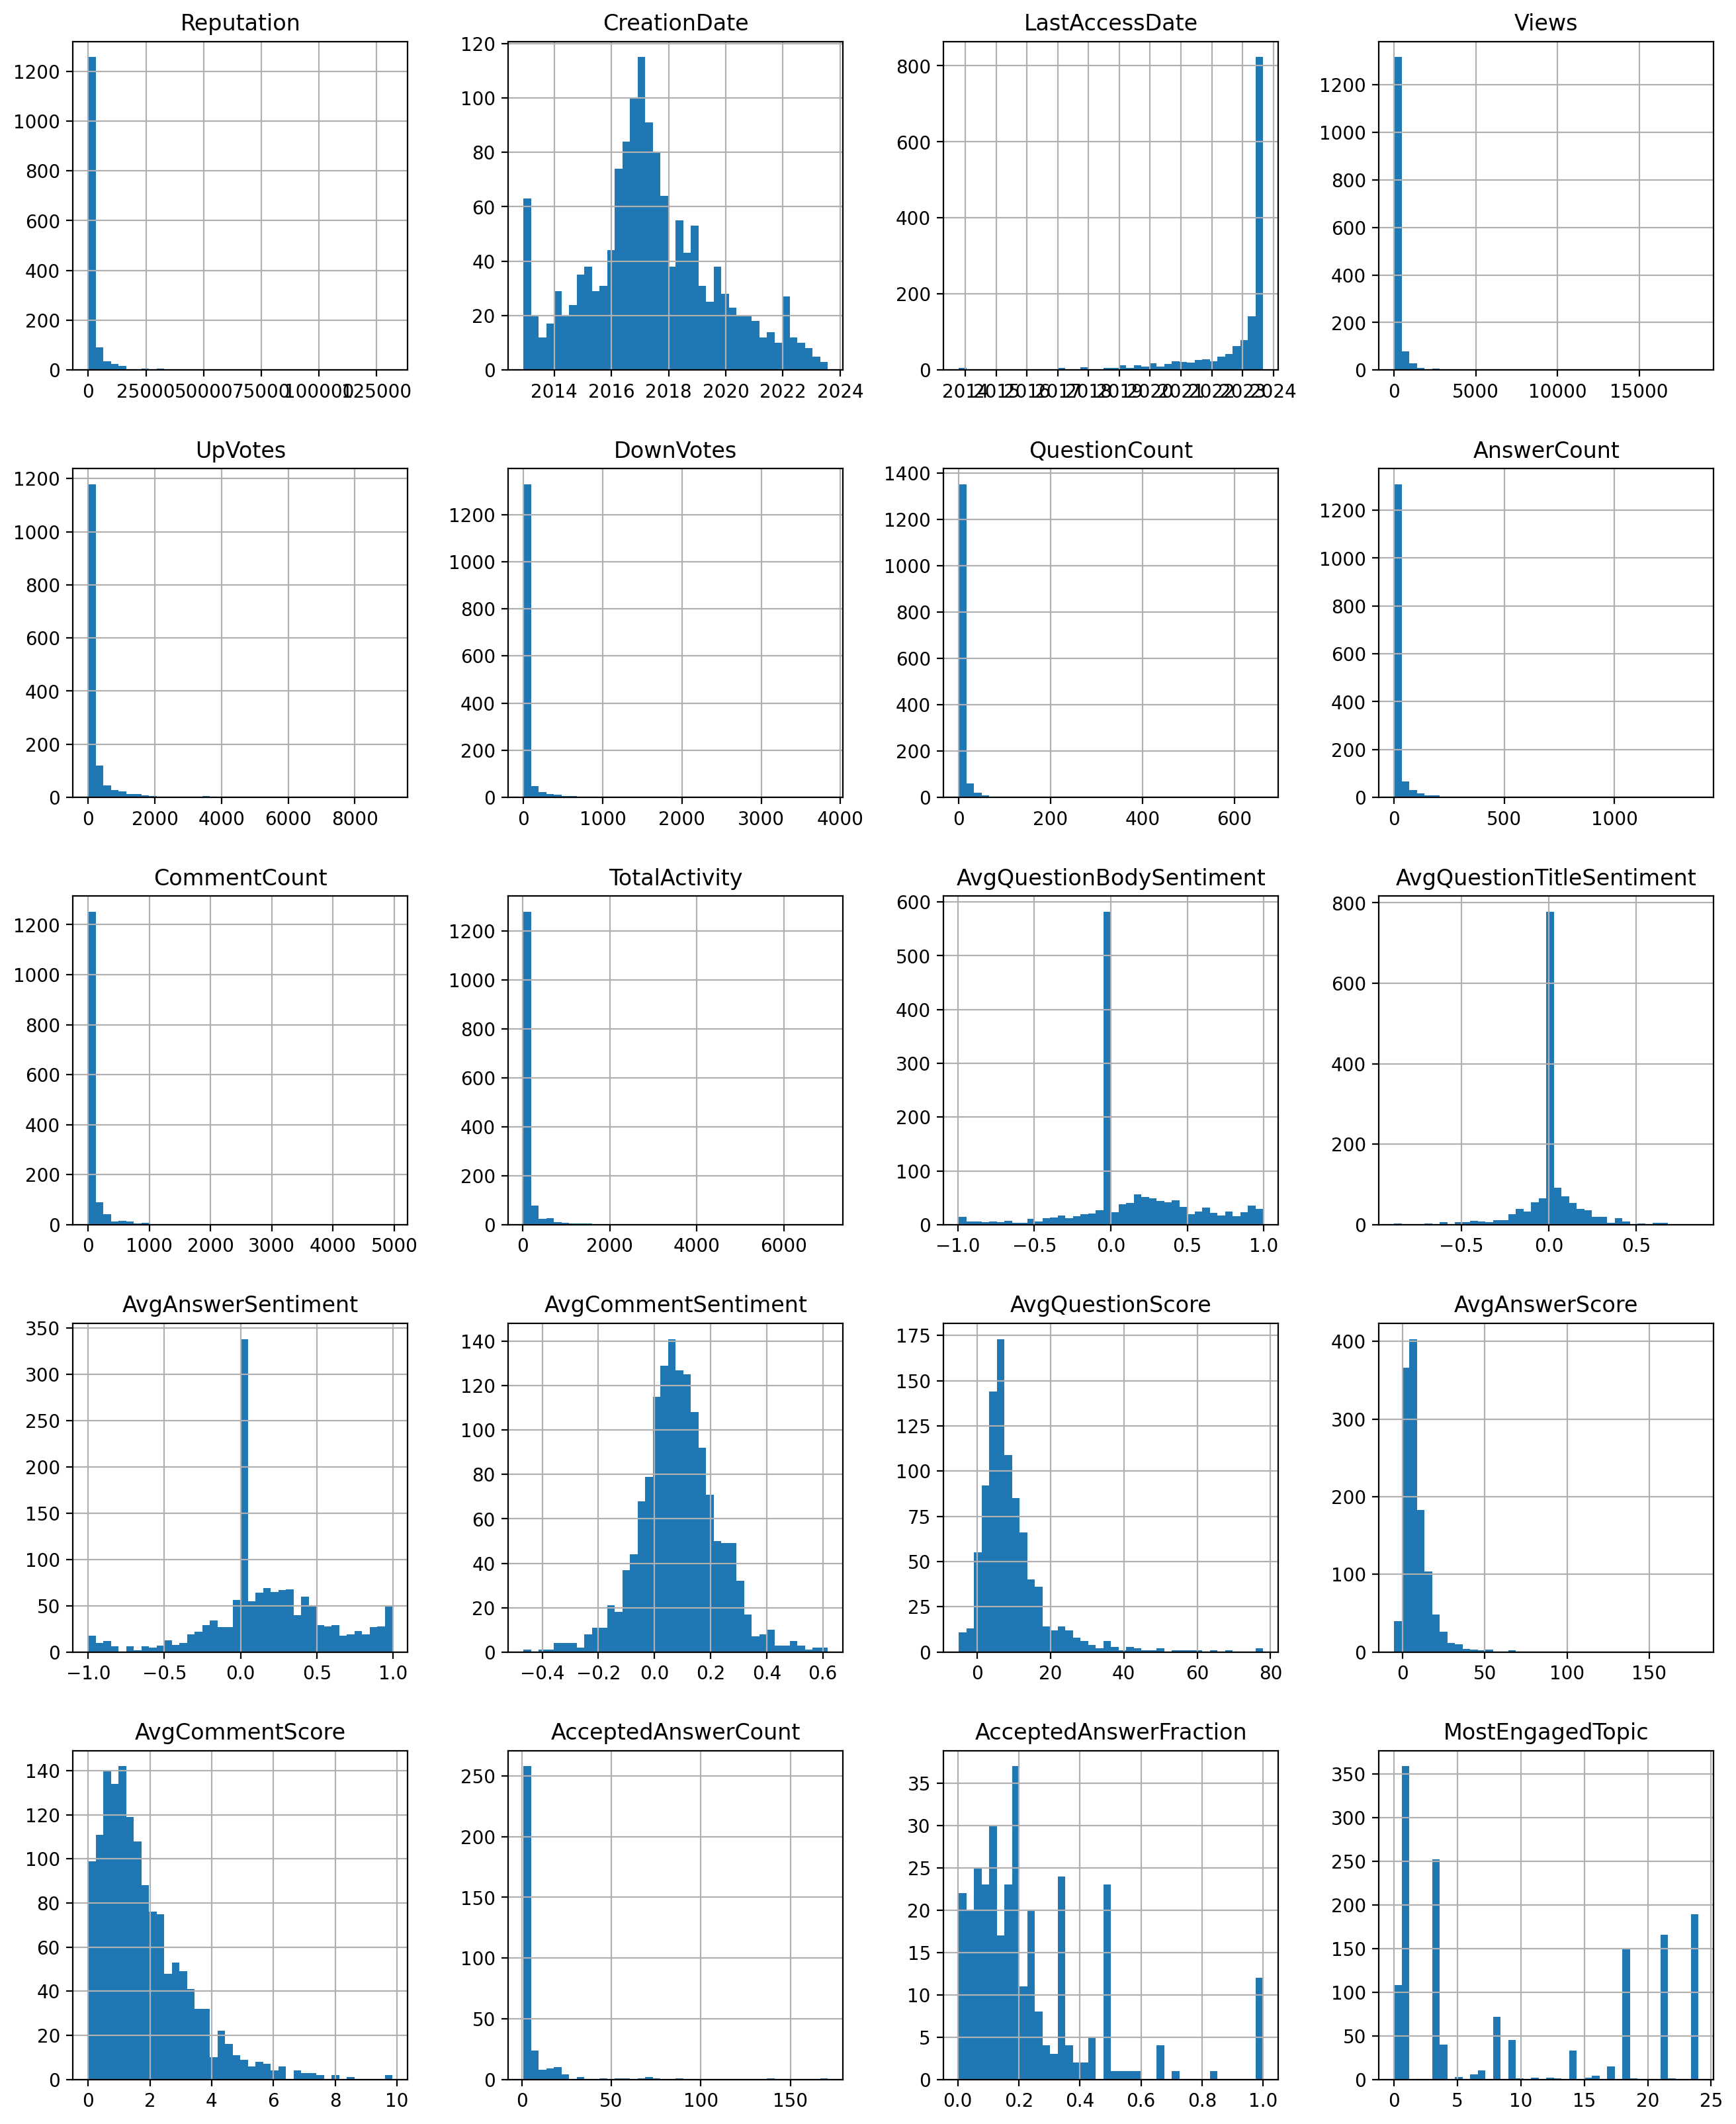

In [ ]:
# Display a histogram of specified columns in the dataframe to gain insight into the data
users_with_all_attributes.iloc[:, 1:-26].join(users_with_all_attributes.iloc[:, -1]).hist(bins=40, figsize=(16, 20))  # Excludes the ID column and single-topic engagement columns

plt.show()

In [ ]:
def custom_cluster(df, clustering_features, n_clusters, clustering_name, random_state=42, verbose=False, minmax=True):
    '''
    This function accepts a DataFrame, a list of features for clustering, and a clustering name. To determine 
    the optimal number of clusters, you can run the function with any value for n_clusters and set verbose to True. 
    This will generate elbow method and silhouette analysis plots. After inspecting these plots, you can rerun 
    the function with n_clusters set to the optimal number of clusters.

    When verbose is enabled, the function also provides additional plots:
    * Distributions among clusters for each of the clustering features are displayed as boxplots.
    * Lineplots illustrate per-feature normalized values across clusters for each of the clustering features. In these lineplots, 
    the cluster with the highest value for each feature is scaled to 1, the cluster with the lowest value is scaled to 0, 
    and the other clusters are plotted on a normalized scale in between. If minmax is set to False, the lineplot simply includes 
    the value of each cluster for each feature (non-normalised).
    '''
    # Impute NaNs and scale features
    features = df[clustering_features].fillna(0)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    df[clustering_name] = kmeans.fit_predict(scaled_features)

    # Display plots
    if verbose:
        # Elbow method and silhouette analysis
        wcss, silhouette_scores = [], []
        for i in range(1, 11):
            kmeans_i = KMeans(n_clusters=i, random_state=random_state).fit(scaled_features)
            wcss.append(kmeans_i.inertia_)
            if i > 1:
                score = silhouette_score(scaled_features, kmeans_i.labels_)
                silhouette_scores.append(score)

        # Plot elbow method and silhouette analysis results
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].plot(range(1, 11), wcss)
        axs[0].set_title('Elbow Method')
        axs[0].set_xlabel('Number of Clusters')
        axs[0].set_ylabel('WCSS')
        axs[0].grid(True)

        axs[1].plot(range(2, 11), silhouette_scores)
        axs[1].set_title('Silhouette Analysis')
        axs[1].set_xlabel('Number of Clusters')
        axs[1].set_ylabel('Silhouette Score')
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

        # Plot boxplots of feature distributions
        num_features = len(clustering_features)
        num_rows = (num_features - 1) // 5 + 1
        num_cols = min(num_features, 5)
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4*num_rows))
        axs = axs.flatten() if num_features > 1 else [axs]
        for i, feature in enumerate(clustering_features):
            sns.boxplot(x=clustering_name, y=feature, data=df, ax=axs[i])
            axs[i].set(title=f'{feature} Distribution', xlabel='Cluster', ylabel='Count')
        for ax in axs[len(clustering_features):]:
            ax.set_visible(False)
        plt.tight_layout()
        plt.show()

    # Compute cluster information
    cluster_counts = df[clustering_name].value_counts().sort_index().reset_index(name='Count')
    cluster_means = df.groupby(clustering_name)[clustering_features].mean().add_suffix('Mean')
    cluster_info = pd.merge(cluster_counts, cluster_means, on=clustering_name)

    # Plot lineplot of cluster information
    if verbose:
        if minmax:  # MinMax scaling for lineplot
            minmax_scaler = MinMaxScaler()
            mean_feature_names = [f'{feature}Mean' for feature in clustering_features]
            scaled = cluster_info[mean_feature_names].apply(lambda x: minmax_scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
            scaled[clustering_name] = cluster_info[clustering_name]
            melted = scaled.melt(id_vars=[clustering_name], var_name='Feature', value_name='NormalizedValue')
            ylabel = "Per-Feature Normalised Value"
        else:  # Absolute values for lineplot
            melted = cluster_info.drop('Count', axis=1).melt(id_vars=[clustering_name], var_name='Feature', value_name='Mean')
            ylabel = "Mean Value"

        plt.figure(figsize=(10, 5))
        value_column = 'NormalizedValue' if minmax else 'Mean'
        title = "Per-Feature Normalised Values Across Clusters" if minmax else "Mean Values of Features Across Clusters"
        for cluster in melted[clustering_name].unique():
            data = melted[melted[clustering_name] == cluster]
            plt.plot(data['Feature'], data[value_column], label=f'Cluster {cluster}')
        plt.title(title)
        plt.xlabel("Feature")
        plt.ylabel(ylabel)
        plt.xticks(rotation=45)
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()

    return cluster_info

In [ ]:
def permutation_test_clustering(df, clustering_name, clustering_features, num_permutations=1000, verbose=False):
    '''
    This function accepts a DataFrame, a clustering name, and a list of features for clustering. It performs a permutation 
    test to assess the significance of a clustering algorithm's performance using the silhouette score.
    '''
    # Impute NaNs and scale features
    features = df[clustering_features].fillna(0)
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Compute silhouette score using actual labels
    actual_labels = df[clustering_name].values
    actual_silhouette_score = silhouette_score(scaled_features, actual_labels)
    
    # Compute silhouette scores using permuted labels
    permuted_silhouette_scores = []
    for _ in range(num_permutations):
        shuffled_labels = np.random.permutation(actual_labels)
        permuted_silhouette_score = silhouette_score(scaled_features, shuffled_labels)
        permuted_silhouette_scores.append(permuted_silhouette_score)

    # Calculate p-value for significance testing
    p_value = (np.sum(np.array(permuted_silhouette_scores) >= actual_silhouette_score) + 1) / (num_permutations + 1)

    if verbose:
        print(f'Actual silhouette score: {actual_silhouette_score}')
        print(f'p-value: {p_value}')

    return actual_silhouette_score, p_value

### 1. Clustering by Activity Metrics

#### 1.1 Clustering by question count, answer count, and comment count

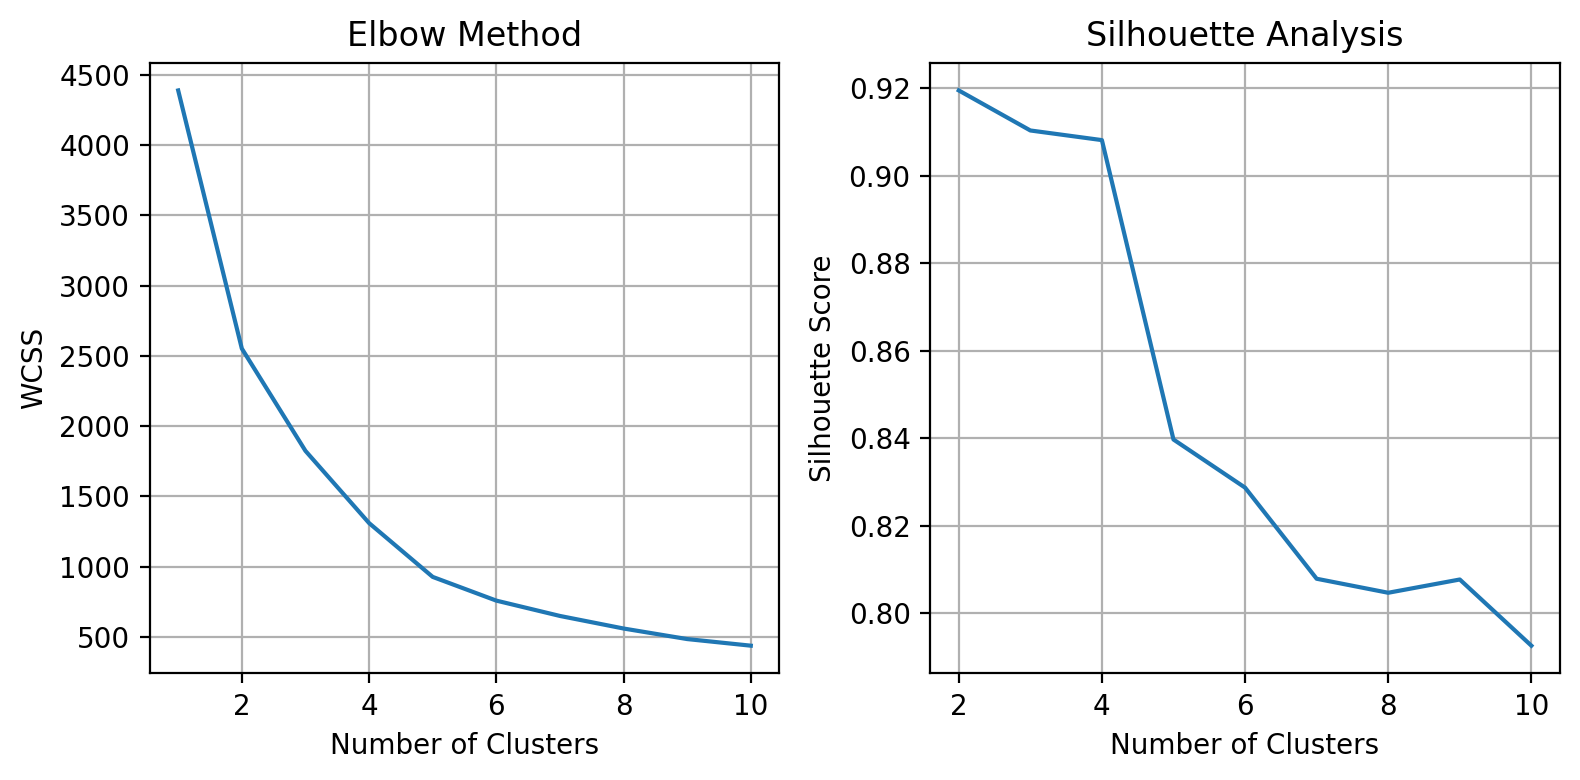

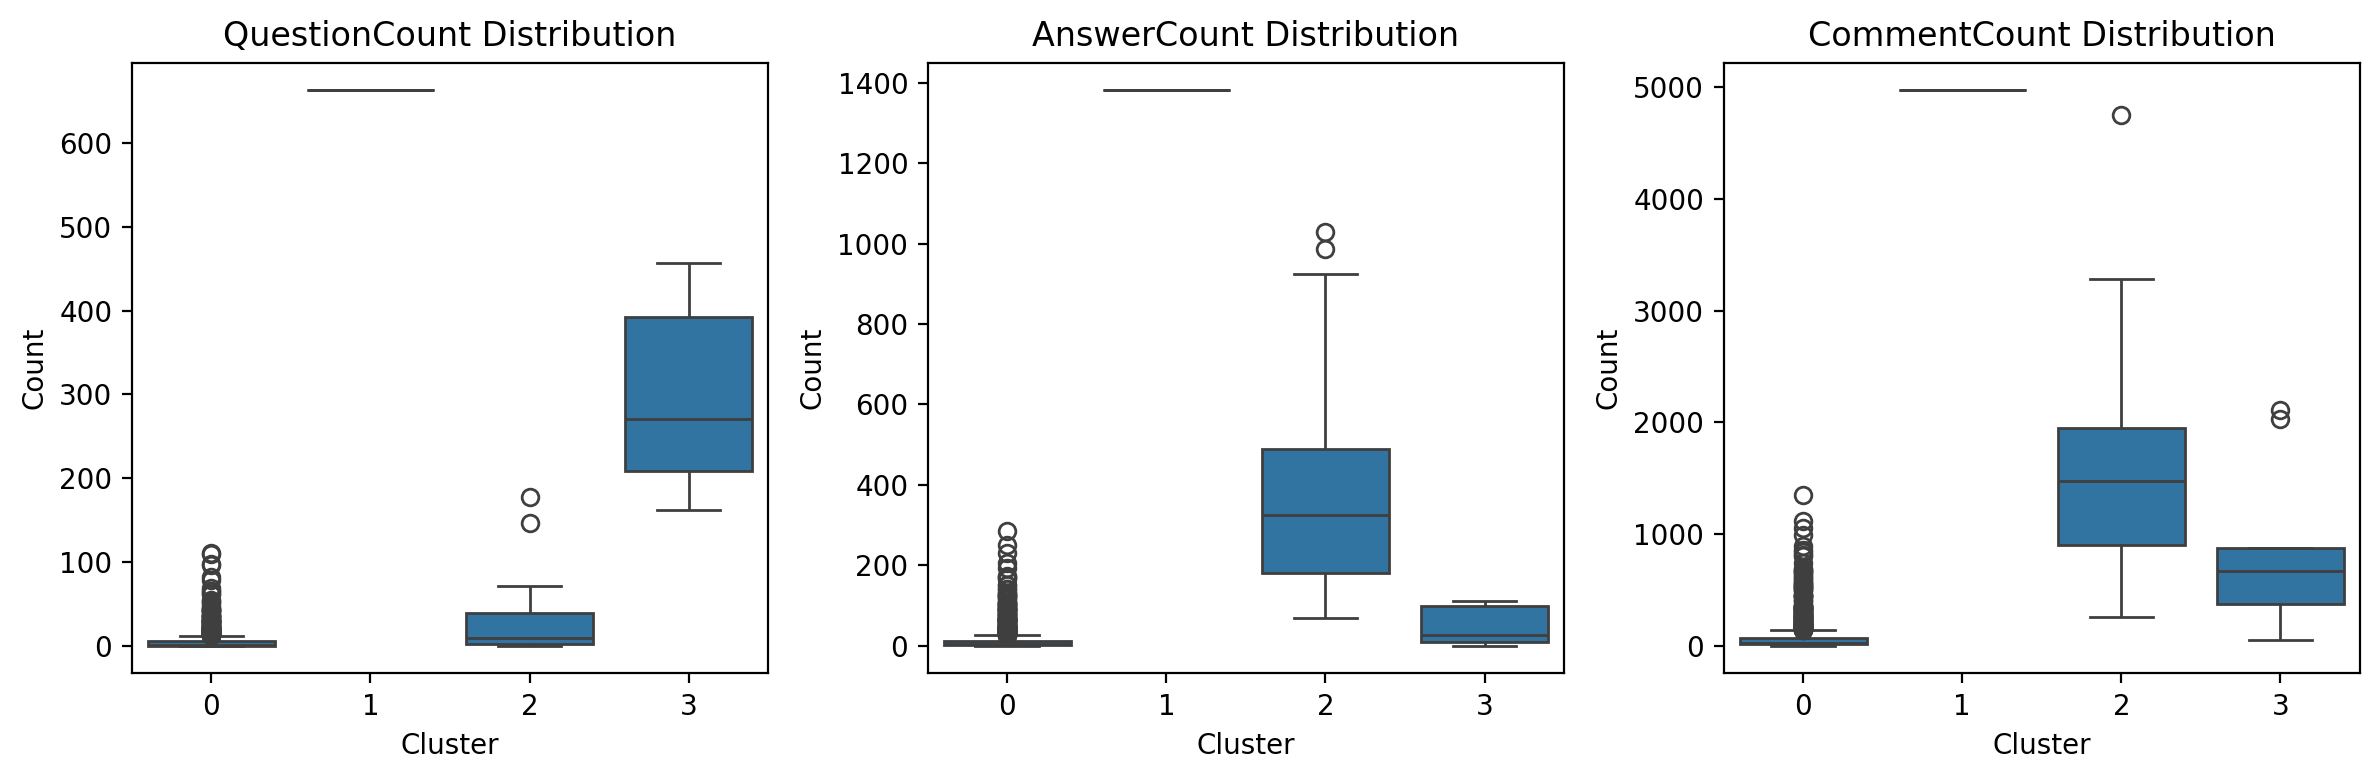

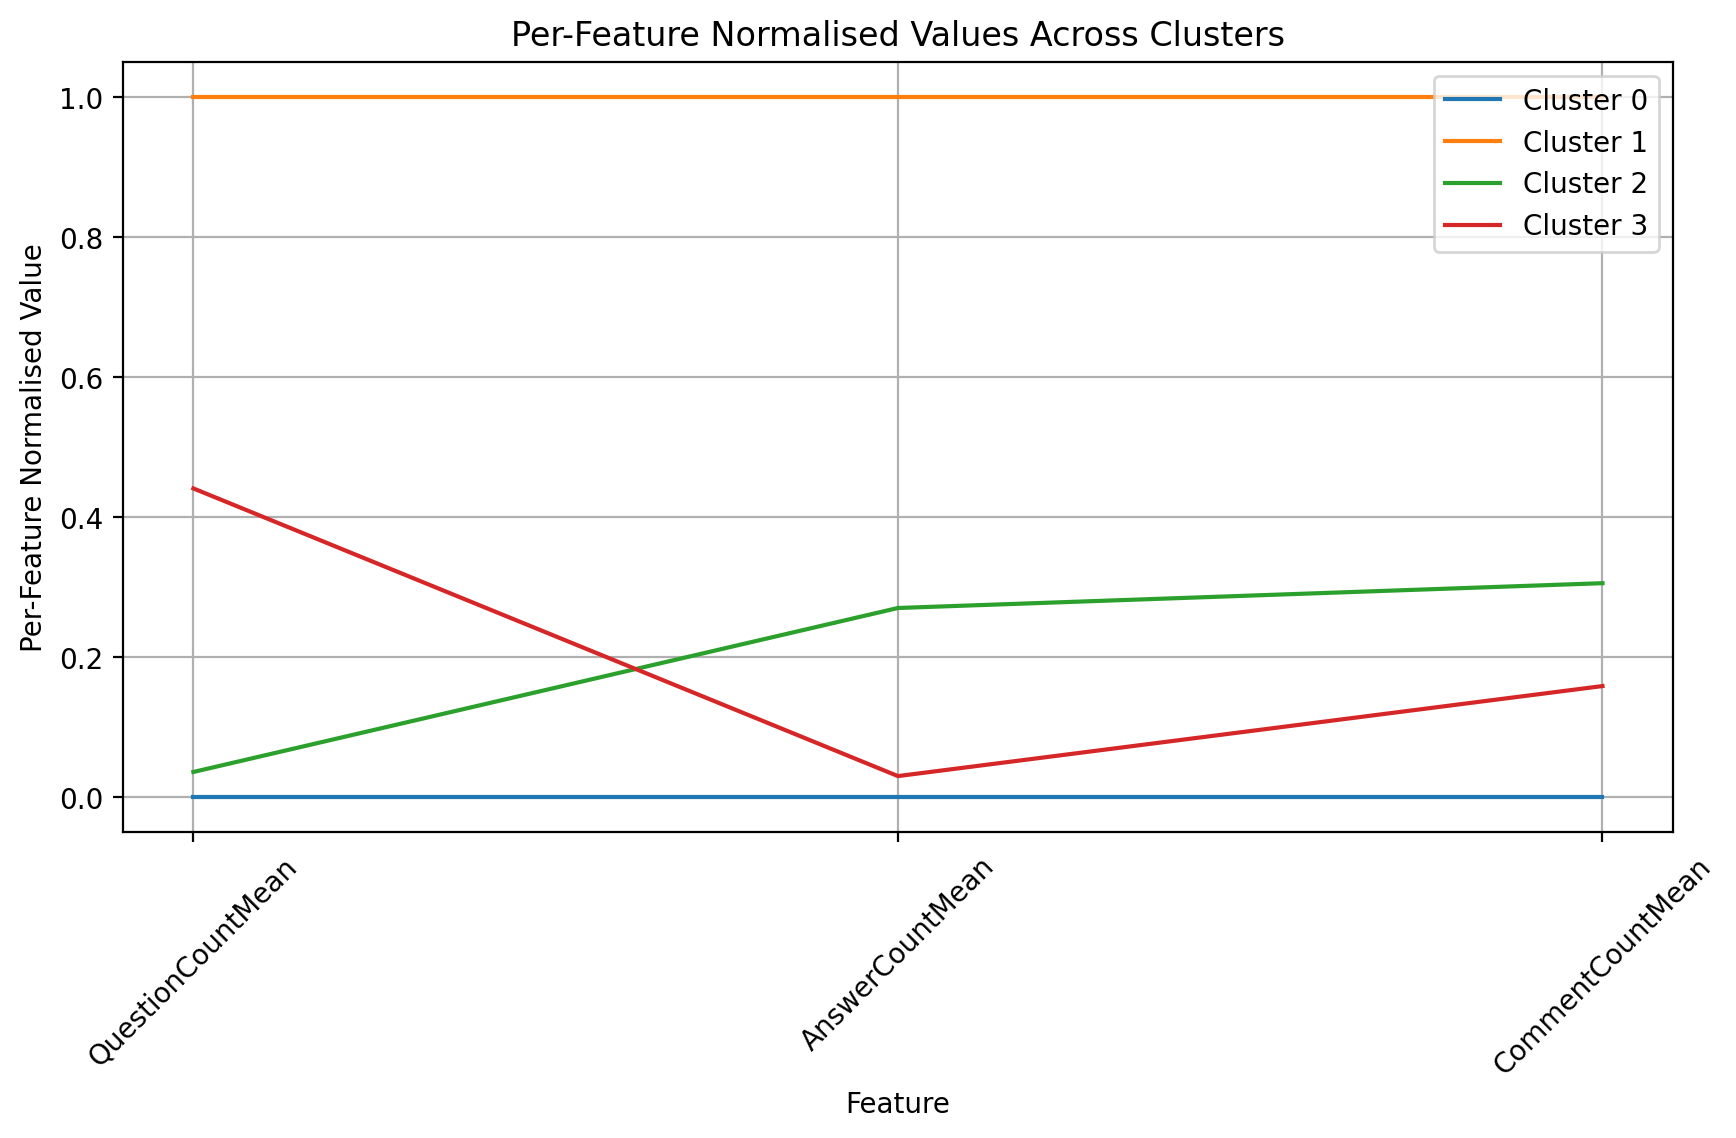

,ActivityCluster,Count,QuestionCountMean,AnswerCountMean,CommentCountMean
0,0,1424,4.517556,12.245787,70.413624
1,1,1,663.000000,1381.000000,4972.000000
2,2,29,27.827586,381.344828,1565.896552
3,3,9,294.555556,52.666667,845.555556


In [ ]:
clustering_features = ['QuestionCount', 'AnswerCount', 'CommentCount']
clustering_name = 'ActivityCluster'

custom_cluster(users_with_all_attributes, clustering_features, 4, clustering_name, verbose=True)

In [ ]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

Actual silhouette score: 0.9081609059757345
p-value: 0.000999000999000999


### 2. Clustering by Quality Metrics

#### 2.1 Clustering by reputation, average question score, average answer score, and average comment score

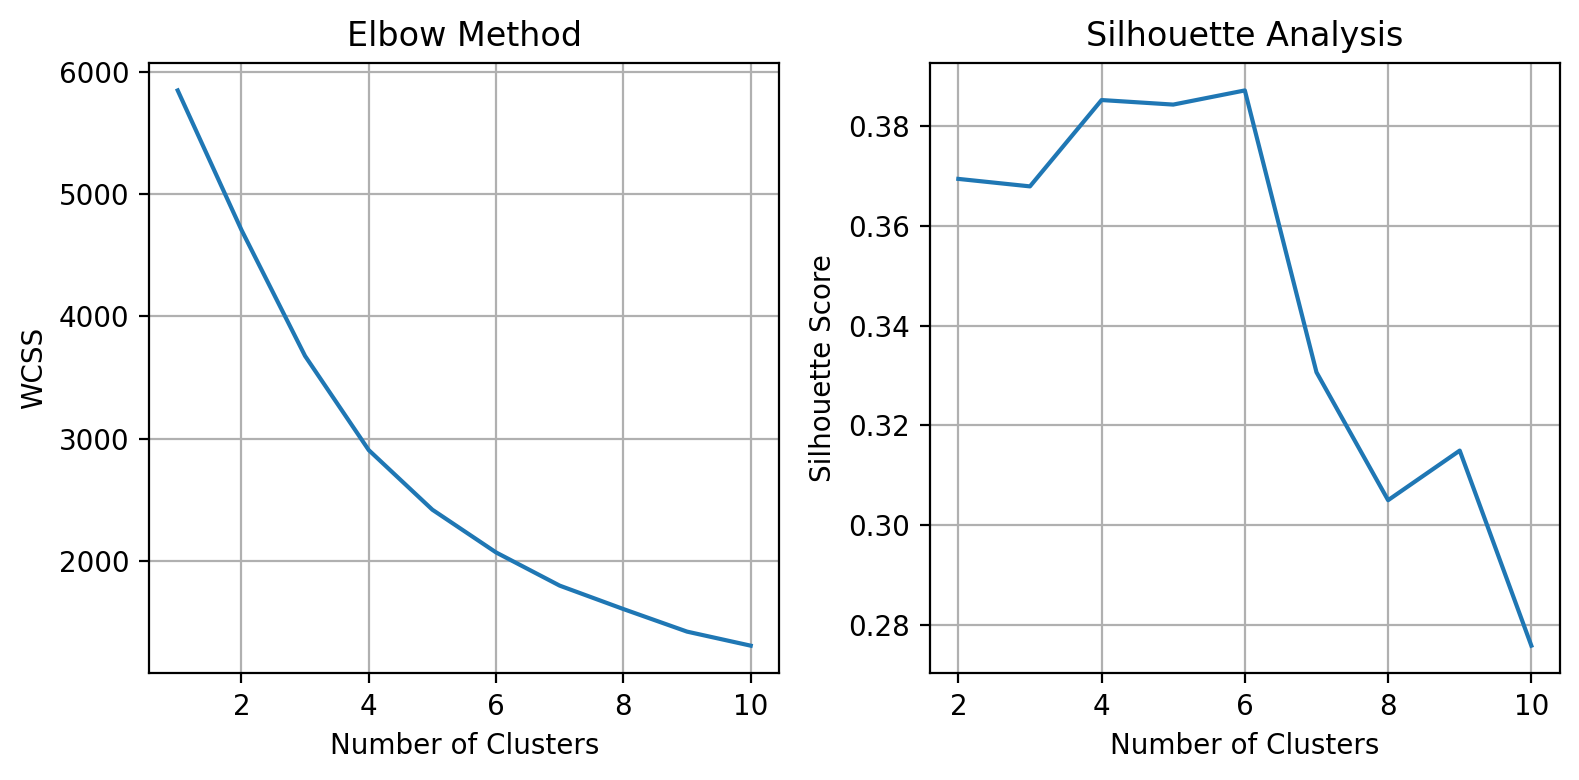

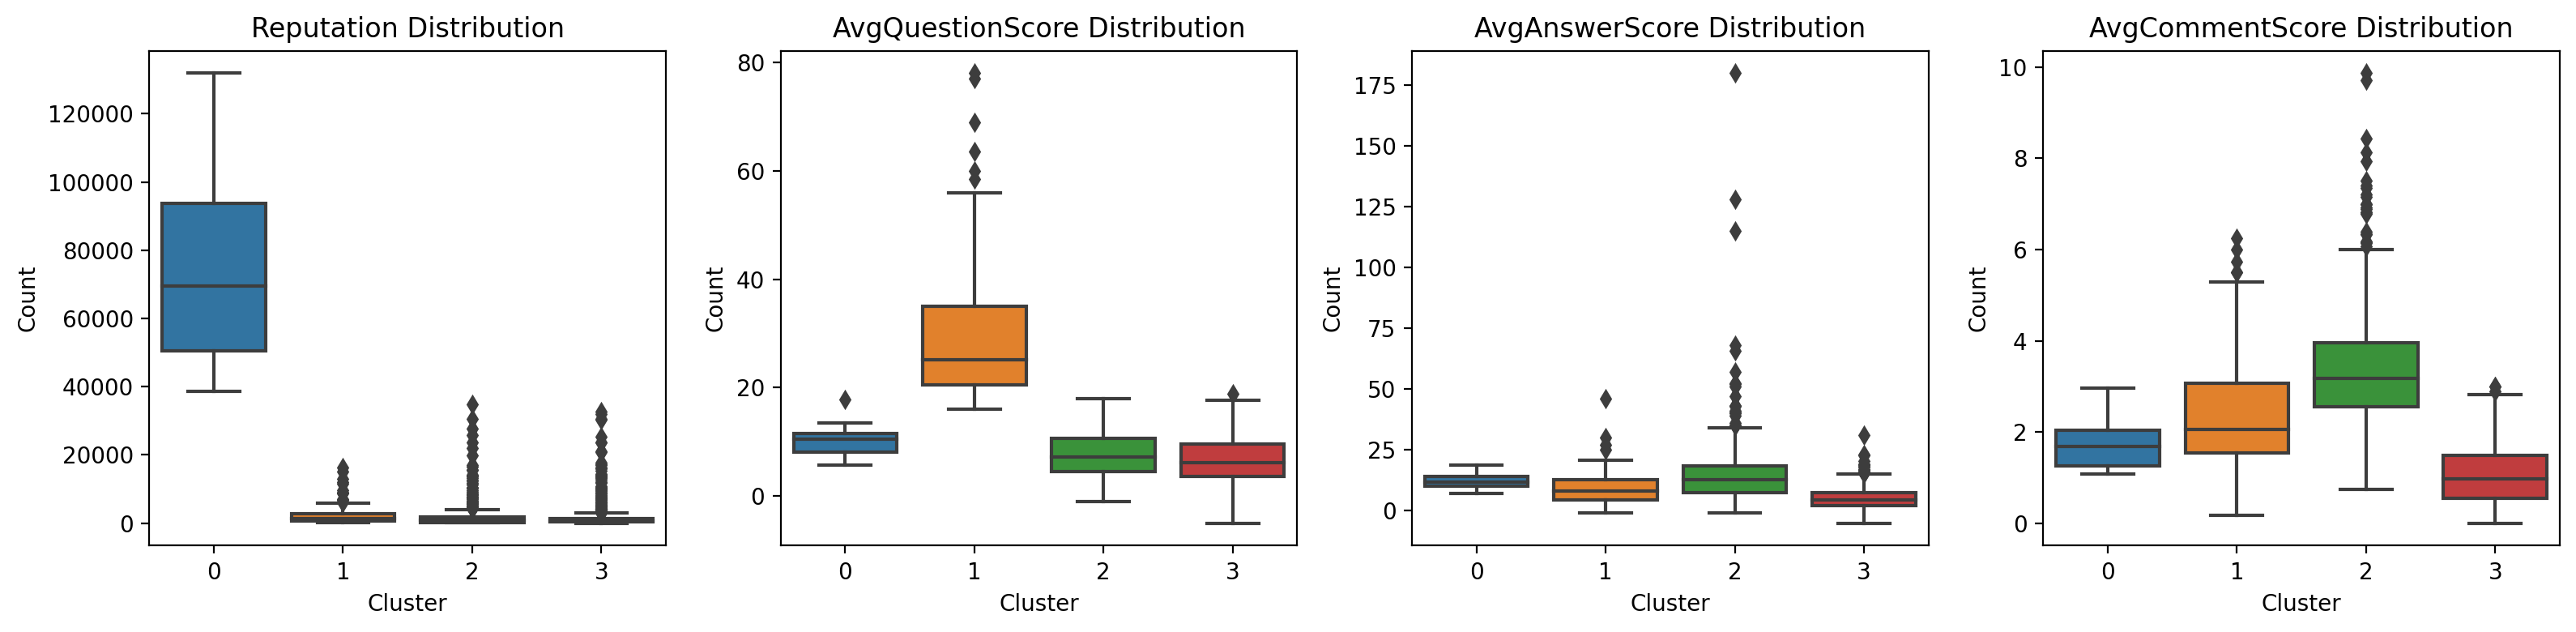

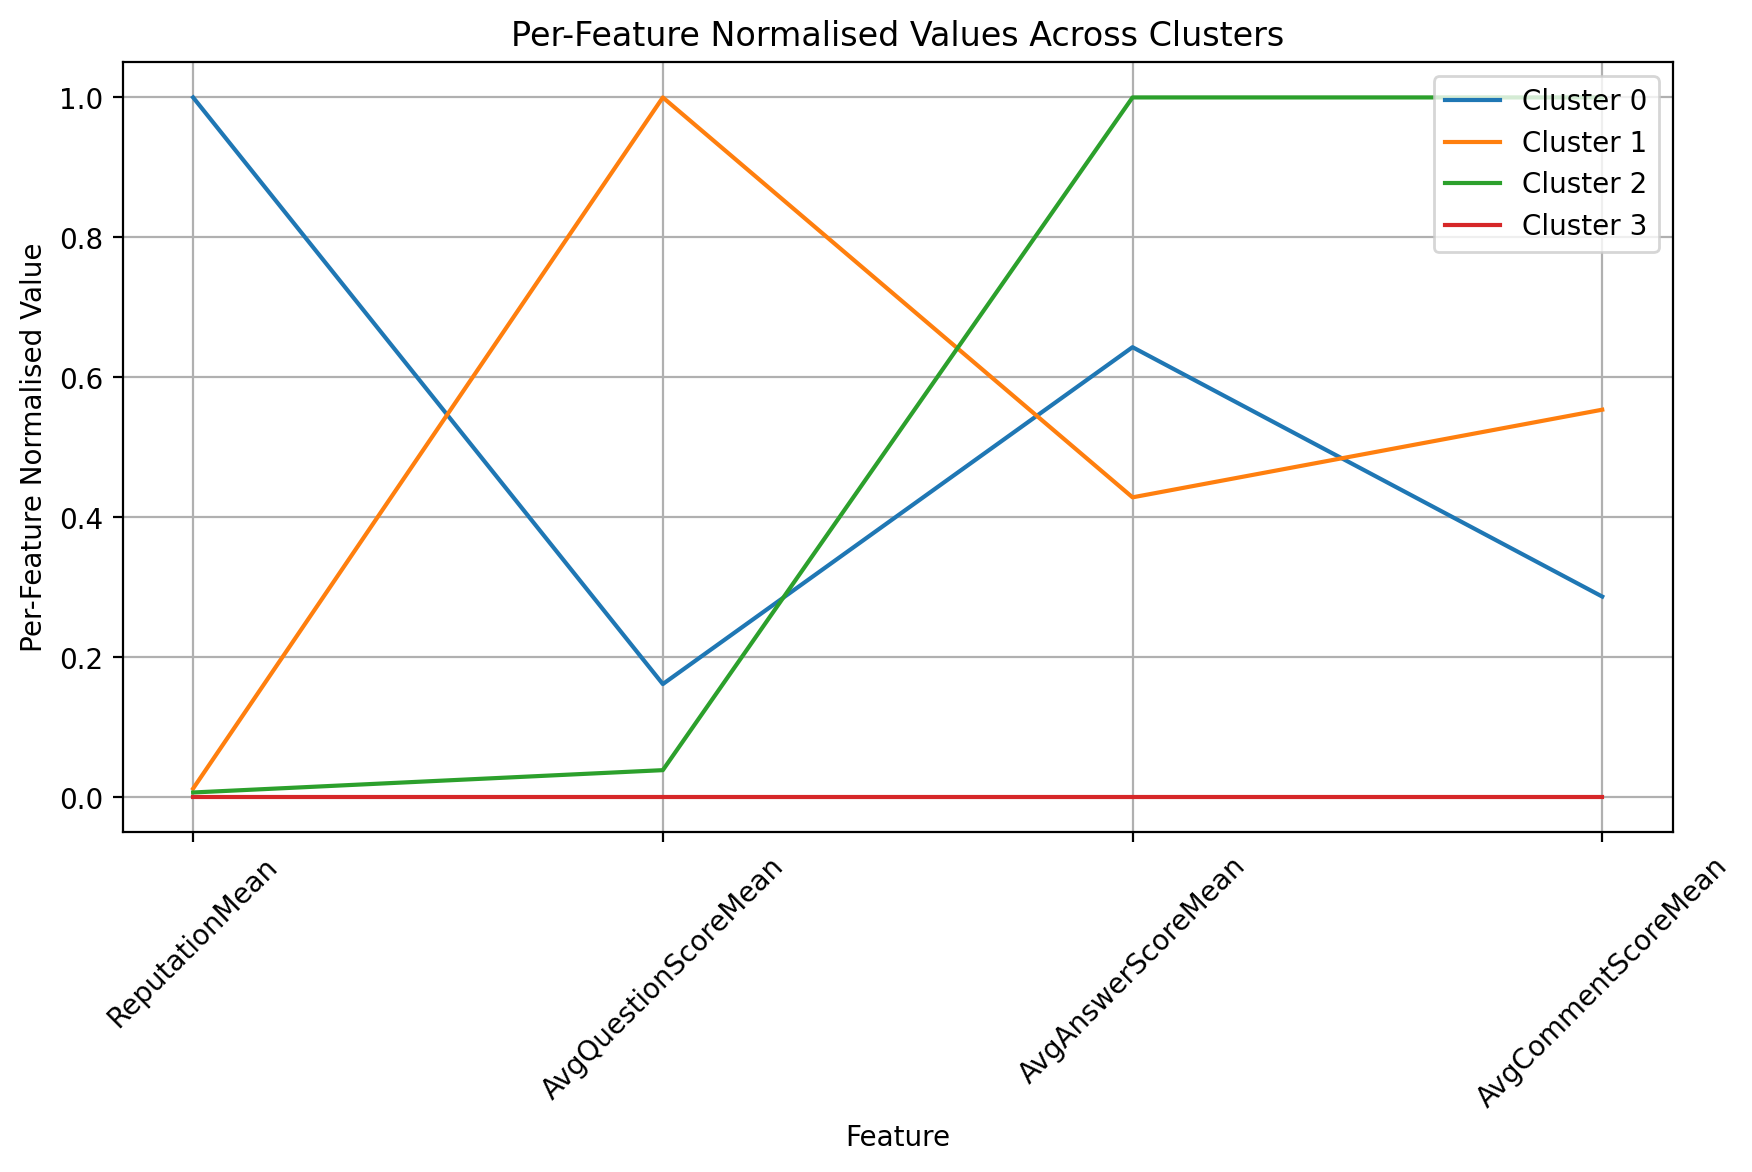

,QualityCluster1,Count,ReputationMean,AvgQuestionScoreMean,AvgAnswerScoreMean,AvgCommentScoreMean
0,0,16,74118.812500,10.385368,11.852085,1.729446
1,1,105,2632.095238,29.546801,9.559383,2.368631
2,2,409,2223.853301,7.573918,15.665143,3.436663
3,3,933,1711.833869,6.682733,4.977559,1.042431


In [ ]:
clustering_features = ['Reputation', 'AvgQuestionScore', 'AvgAnswerScore', 'AvgCommentScore']
clustering_name = 'QualityCluster1'

custom_cluster(users_with_all_attributes, clustering_features, 4, clustering_name, verbose=True)

In [ ]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

Actual silhouette score: 0.3853100990662119
p-value: 0.000999000999000999


#### 2.2 Clustering by accepted answer count and accepted answer fraction

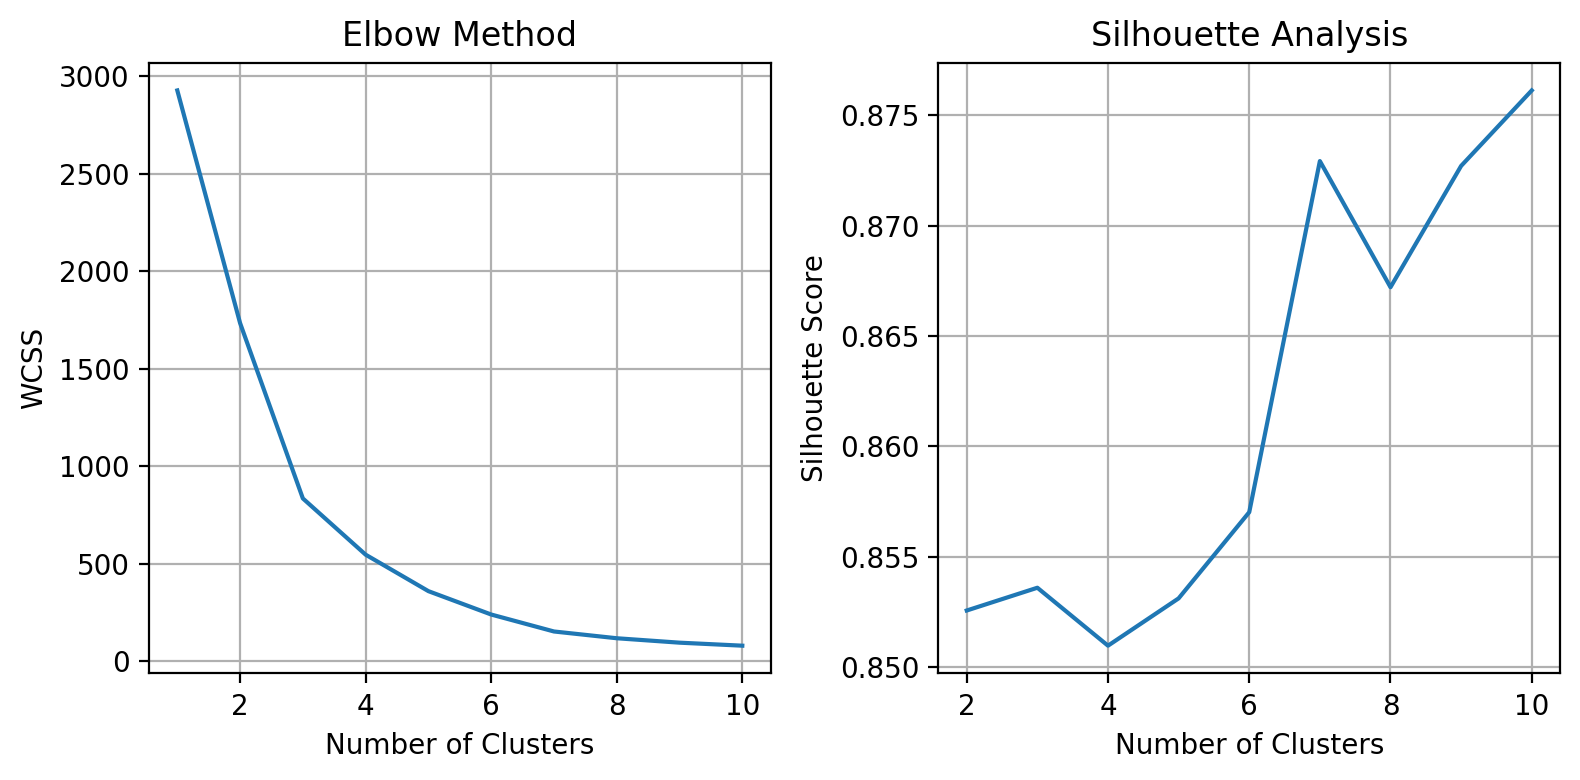

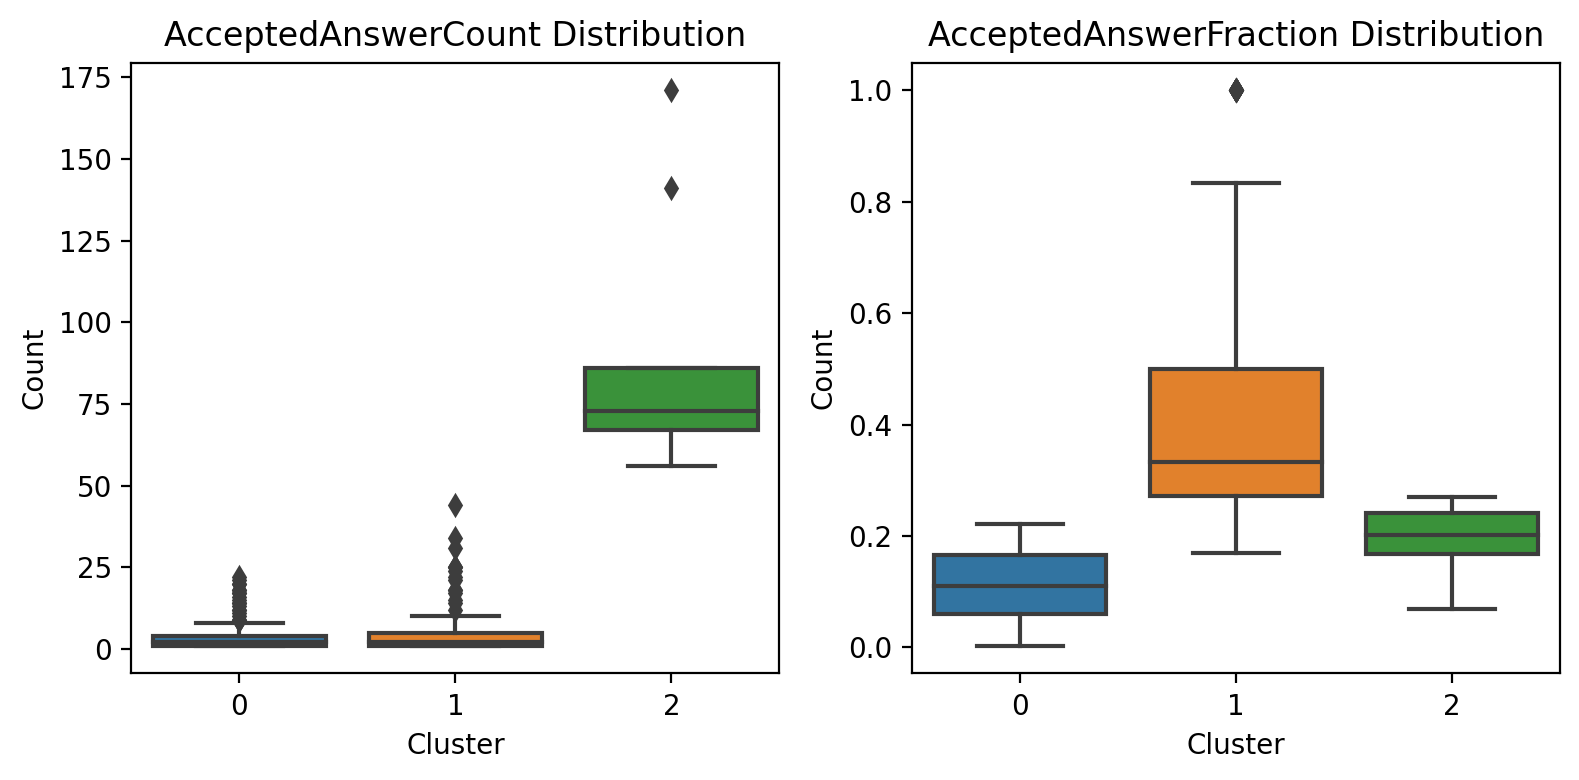

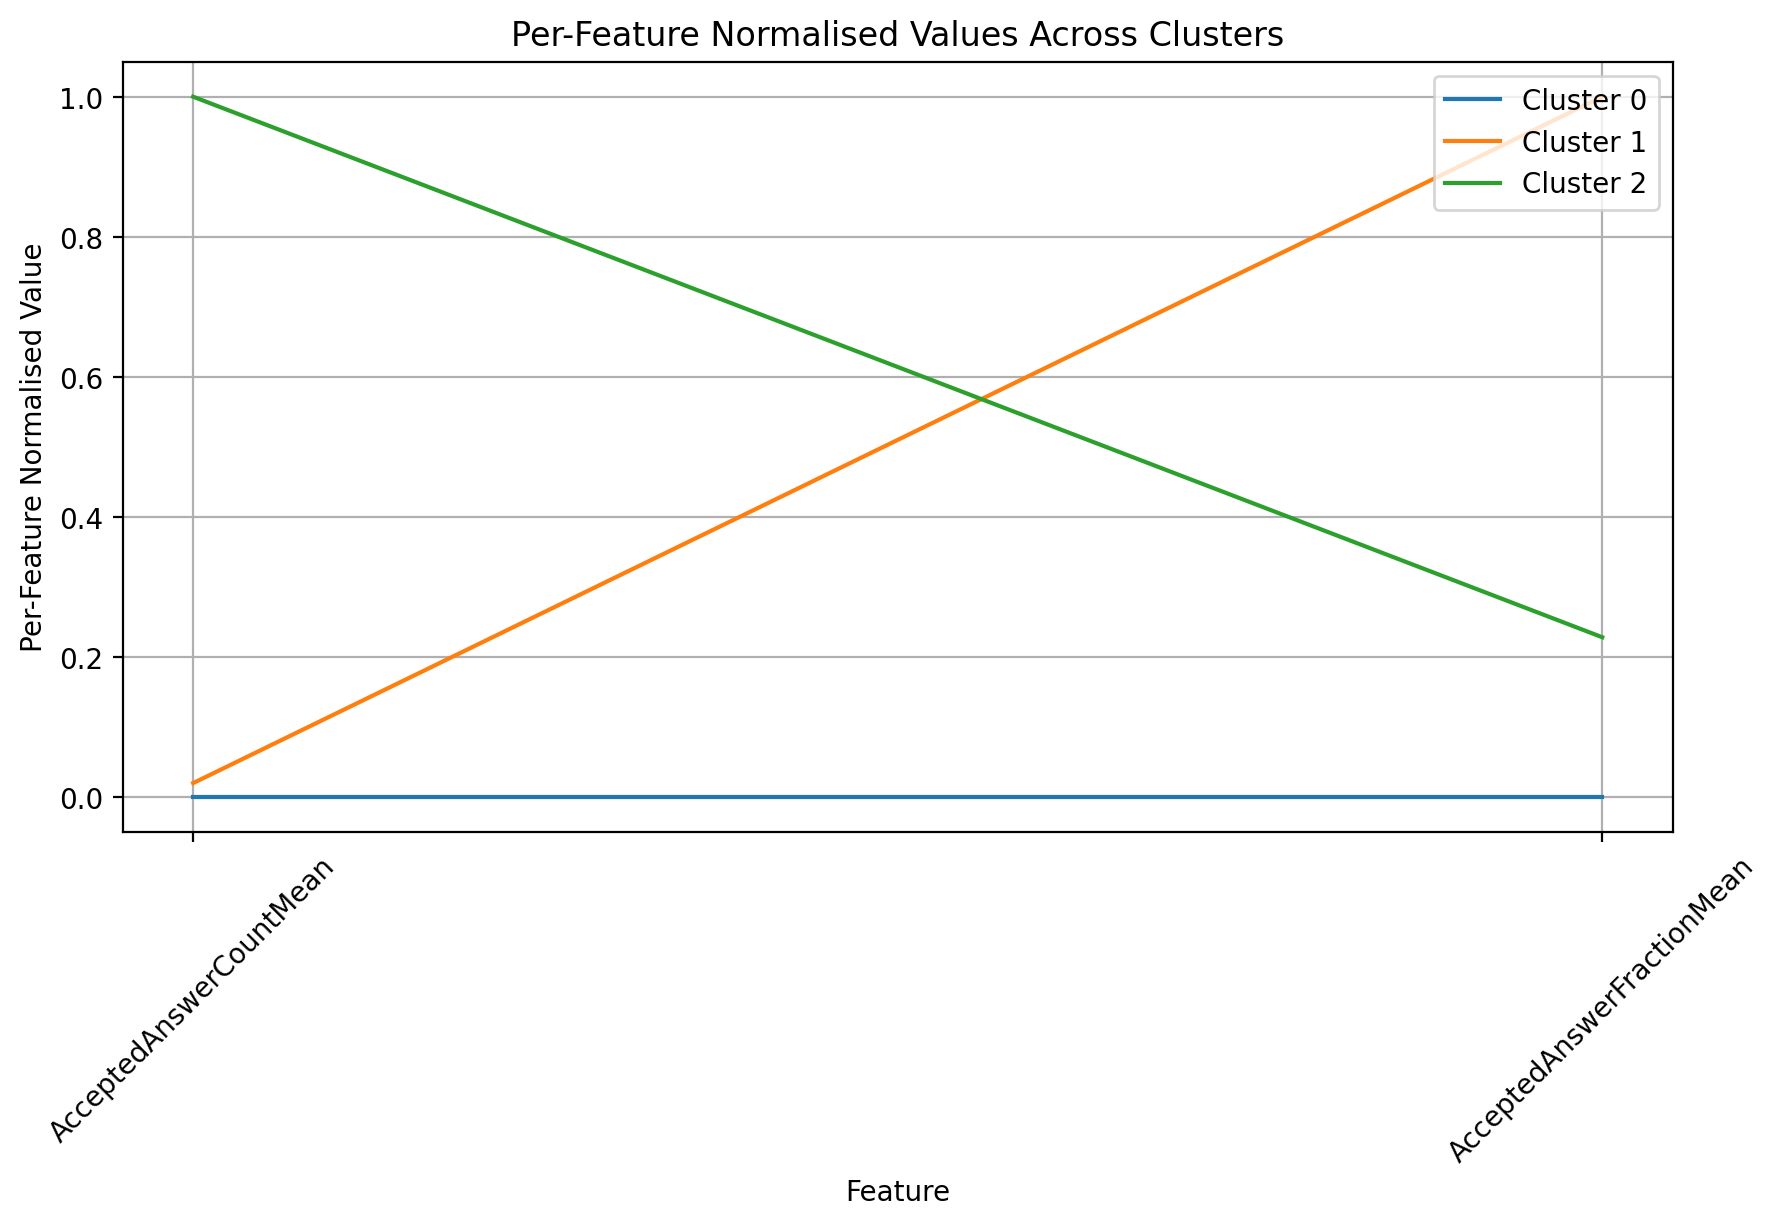

,QualityCluster2,Count,AcceptedAnswerCountMean,AcceptedAnswerFractionMean
0,0,1334,3.505102,0.112406
1,1,120,5.166667,0.440166
2,2,9,88.888889,0.187083


In [ ]:
clustering_features = ['AcceptedAnswerCount', 'AcceptedAnswerFraction']
clustering_name = 'QualityCluster2'

custom_cluster(users_with_all_attributes, clustering_features, 3, clustering_name, verbose=True)

In [ ]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

Actual silhouette score: 0.8535996779648711
p-value: 0.000999000999000999


### 3. Clustering by Sentiment Metrics

#### 3.1 Clustering by average question body sentiment, average question title sentiment, average answer sentiment, average comment sentiment

In [ ]:
clustering_features = ['AvgQuestionBodySentiment', 'AvgQuestionTitleSentiment', 'AvgAnswerSentiment', 'AvgCommentSentiment']
clustering_name = 'SentimentCluster'

custom_cluster(users_with_all_attributes, clustering_features, 4, clustering_name, verbose=True)

In [ ]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

### 4. Clustering by Engagement Metrics

#### 4.1 Clustering by views, upvotes, and downvotes

In [ ]:
clustering_features = ['Views', 'UpVotes', 'DownVotes']
clustering_name = 'EngagementCluster'

custom_cluster(users_with_all_attributes, clustering_features, 3, clustering_name, verbose=True)

In [ ]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

### 5. Clustering by Topic Engagement Metrics

#### 5.1 Clustering by topic engagement columns

In [ ]:
clustering_features = list(range(25))
clustering_name = 'TopicEngagementCluster'

custom_cluster(users_with_all_attributes, clustering_features, 7, clustering_name, verbose=True, minmax=False)

In [ ]:
permutation_test_clustering(users_with_all_attributes, clustering_name, clustering_features, verbose=True);

#### Assigning Node Attributes

In [ ]:
users_with_all_attributes.columns

In [ ]:
UserAttributesForNetwork = users_with_all_attributes[['Id', 'MostEngagedTopic', 'EngagementCluster', 'ActivityCluster', 'Quality1Cluster', 'Quality2Cluster', 'SentimentCluster', 'EngagementSentimentCluster', 'Engagement_MostEngaged_Cluster']]

In [ ]:
user_attrs = UserAttributesForNetwork.set_index('Id').T.to_dict()
list(user_attrs.items())[:2]

In [ ]:
# Iterate over the user attributes dictionary and add each to the corresponding node
for user_id, attrs in user_attrs.items():
    if user_id in G1.nodes:
        nx.set_node_attributes(G1, {user_id: attrs})

In [ ]:
# Check attributes of a specific user node
print(G1.nodes[5])

In [ ]:
# Save Network to Gephi
# nx.write_graphml(G1, './graphml/graph2.graphml')

### Results

#### Clusters vs. Communities

#### User Attribute Analysis

### Label Reshuffleing

> *"The "label shuffling technique" is incredibly useful. It may turn out to be a good tool to apply for your independent project. Keep it in mind."* - **Week8.ipynb**

Use the "label shuffling test" (Week 5 and 8) to test if the coast with the highest wikipedia page sentiment has a page sentiment that is significantly higher (5% confidence bound) than a randomly selected group of rappers of the same size.

1. Initial Cluster Analysis
Cluster Your Data: Use a clustering algorithm (like k-means) to cluster your users based on the features you're interested in. Assign each user to a cluster.
Compute Initial Statistics: For each cluster, compute the average (or another statistic of interest) of a specific feature or set of features. These are your observed values.
2. Permutation Test Procedure
Shuffle Cluster Labels: Randomly shuffle the cluster labels assigned to the users, ensuring that the number of users in each cluster remains the same as in the original classification.
Recompute Statistics for Shuffled Data: For each shuffled configuration, recompute the same statistics as in your initial analysis for each cluster.
Repeat the Process: Perform this shuffling and recomputing process a large number of times (typically 1000 or more) to build a distribution of the statistic under the null hypothesis.
3. Analysis and Comparison
Create Histograms: For each cluster, create histograms of the computed statistics from the shuffled data.
Compare Observed Values with Distributions: Compare the initially observed values for each cluster with the distributions obtained from the shuffled data. If your observed value lies outside the bulk of the distribution for shuffled data, it suggests that the observed value is not simply due to random chance.
4. Statistical Significance
P-Value Calculation: For each cluster, you can calculate a p-value, which is the proportion of the shuffled datasets where the computed statistic was as extreme as the observed statistic. A small p-value indicates that the observed statistic is unusual under the null hypothesis of random distribution of features.
5. Interpretation
Draw Conclusions: Based on where your observed statistics fall in relation to the distributions from the shuffled data, draw conclusions about whether the features in each cluster are significantly different from what would be expected by chance.